In [1]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import sqlite3
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect("../database.db")

df = pd.read_sql("SELECT * FROM Ticker_1H WHERE Ticker = 'MSFT'", con=conn)
df.head()

,Datetime,Open,High,Low,Close,Volume,Ticker,InsertTime
0,2024-01-16 09:30:00.000000,392.750000,393.700012,389.470001,392.119995,8262760,MSFT,2026-01-13 11:05:14.285670
1,2024-01-16 10:30:00.000000,392.095001,393.220001,390.320007,391.649994,3330125,MSFT,2026-01-13 11:05:14.285670
2,2024-01-16 11:30:00.000000,391.690002,392.319885,389.730011,389.779999,2038955,MSFT,2026-01-13 11:05:14.285670
3,2024-01-16 12:30:00.000000,389.760010,390.000000,387.622894,389.010010,2296409,MSFT,2026-01-13 11:05:14.285670
4,2024-01-16 13:30:00.000000,389.019989,389.750000,388.000000,388.662994,1597837,MSFT,2026-01-13 11:05:14.285670


In [3]:
df.Ticker.drop_duplicates().to_numpy()

array(['MSFT'], dtype=object)

In [4]:
df = df[["Datetime", "Open", "High", "Low", "Close", "Volume"]]
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime")
df.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2024-01-16 09:30:00,392.750000,393.700012,389.470001,392.119995,8262760
2024-01-16 10:30:00,392.095001,393.220001,390.320007,391.649994,3330125
2024-01-16 11:30:00,391.690002,392.319885,389.730011,389.779999,2038955
2024-01-16 12:30:00,389.760010,390.000000,387.622894,389.010010,2296409
2024-01-16 13:30:00,389.019989,389.750000,388.000000,388.662994,1597837


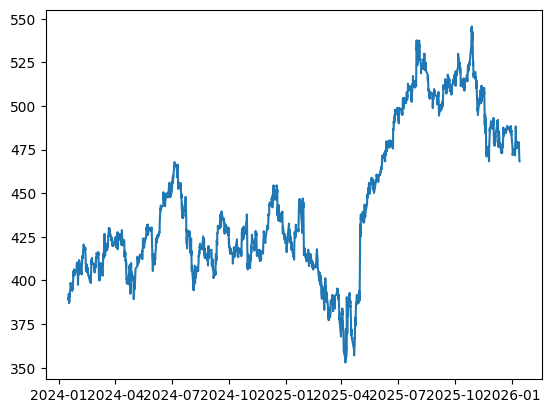

In [5]:
plt.plot(df.index, df.Close)

In [6]:
from sklearn.preprocessing import StandardScaler

train_size = 2800
val_size = 300

df_np = df.to_numpy()
scale_to = df.to_numpy()[:train_size]
labels = df.Close.to_numpy()

scaler = StandardScaler()
scaler.fit(scale_to)

df_np = scaler.transform(df_np)

In [8]:
[label for label in labels[5:10]]


[np.float64(389.4700012207031),
 np.float64(390.2699890136719),
 np.float64(387.010009765625),
 np.float64(389.2099914550781),
 np.float64(388.7200012207031)]

In [33]:
def create_window(predictors, labels, window_size=5):
    df_np = predictors
    X = []
    y = []


    for i in range(len(df_np) - (2*window_size)):
        row = np.array([[a] for a in df_np[i:i+window_size]]).reshape(window_size, 5) # Does [[a] [b] [c]...]
        label = [label for label in labels[i+window_size:i+(2*window_size)]]

        X.append(row)
        y.append(label)

    return np.array(X), np.array(y)

In [34]:
X, y = create_window(df_np, labels, 5)
X.shape, y.shape

((3468, 5, 5), (3468, 5))

In [40]:
y[0, 1]

np.float64(390.2699890136719)

In [42]:
X_train = X[:train_size]
y1_train, y2_train, y3_train, y4_train, y5_train = y[:train_size, 0], y[:train_size, 1], y[:train_size, 2], y[:train_size, 3], y[:train_size, 4]
X_val = X[train_size:train_size+val_size] 
y1_val, y2_val, y3_val, y4_val, y5_val = y[train_size:train_size+val_size, 0], y[train_size:train_size+val_size, 1], y[train_size:train_size+val_size, 2], y[train_size:train_size+val_size, 3], y[train_size:train_size+val_size, 4]
X_test = X[train_size+val_size:]
y1_test, y2_test, y3_test, y4_test, y5_test,  = y[train_size+val_size:, 0], y[train_size+val_size:, 1], y[train_size+val_size:, 2], y[train_size+val_size:, 3], y[train_size+val_size:, 4]

X_train.shape, y1_train.shape, X_val.shape, y1_val.shape, X_test.shape, y1_test.shape

((2800, 5, 5), (2800,), (300, 5, 5), (300,), (368, 5, 5), (368,))

In [ ]:
# X_train, y_train = X_train.reshape(X_train.shape[:3]), y_train.reshape(y_train.shape[:3])
# X_val, y_val = X_val.reshape(X_val.shape[:3]), y_val.reshape(y_val.shape[:3])
# X_test, y_test = X_test.reshape(X_test.shape[:3]), y_test.reshape(y_test.shape[:3])

# X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2800, 5, 1), (2800, 1), (300, 5, 1), (300, 1), (373, 5, 1), (373, 1))

In [30]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [43]:

input_layer = Input((5, 5), name="input")

x = LSTM(128)(input_layer)
x = Dense(8, "relu")(x)

output_1 = Dense(1, "linear", name="1_future")(x)
output_2 = Dense(1, "linear", name="2_future")(x)
output_3 = Dense(1, "linear", name="3_future")(x)
output_4 = Dense(1, "linear", name="4_future")(x)
output_5 = Dense(1, "linear", name="5_future")(x)

model2 = Model(inputs=input_layer, outputs=[output_1, output_2, output_3, output_4, output_5])

model2.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 5, 5)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 128)       │     68,608 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 8)         │      1,032 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 1_future (Dense)    │ (None, 1)         │          9 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 2_future (Dense)    │ (None, 1)         │          9 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 3_future (Dense)    │ (None, 1)         │          9 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 4_future (Dense)    │ (None, 1)         │          9 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ 5_future (Dense)    │ (None, 1)         │          9 │ dense_21[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,685 (272.21 KB)

 Trainable params: 69,685 (272.21 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
mcp = ModelCheckpoint("model1/best_model.keras", save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001))
model2.fit(X_train, [y1_train, y2_train, y3_train, y4_train, y5_train], 
           validation_data=(X_val, [y1_val, y2_val, y3_val, y4_val, y5_val]), 
           epochs=100, callbacks=[mcp])

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - 1_future_loss: 179943.9844 - 2_future_loss: 182143.3438 - 3_future_loss: 186124.3125 - 4_future_loss: 187150.5625 - 5_future_loss: 176194.3125 - loss: 911973.8750 - val_1_future_loss: 235244.7031 - val_2_future_loss: 244711.3438 - val_3_future_loss: 260160.4062 - val_4_future_loss: 264669.3750 - val_5_future_loss: 221339.4219 - val_loss: 1222923.6250
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - 1_future_loss: 147813.6875 - 2_future_loss: 159643.4375 - 3_future_loss: 178046.0938 - 4_future_loss: 183934.1250 - 5_future_loss: 132709.1094 - loss: 802697.9375 - val_1_future_loss: 195819.9688 - val_2_future_loss: 214474.4688 - val_3_future_loss: 242619.5781 - val_4_future_loss: 252038.5000 - val_5_future_loss: 173602.6719 - val_loss: 1075557.7500
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - 1_future_loss: 114391.6328 - 2_future_loss: 132029.2344 - 3_future_loss: 158921.2188 - 4_future_loss: 168311.6875 - 5_future_loss: 9475

In [45]:
from tensorflow.keras.models import load_model

model1_loaded = load_model("model1/best_model.keras")

In [54]:
y1_pred = model1_loaded.predict(X_test)[0].flatten()
y2_pred = model1_loaded.predict(X_test)[1].flatten()
y3_pred = model1_loaded.predict(X_test)[2].flatten()
y4_pred = model1_loaded.predict(X_test)[3].flatten()
y5_pred = model1_loaded.predict(X_test)[4].flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [55]:
train_true = np.full((len(X)), np.nan)
val_true = np.full((len(X)), np.nan)
test_true = np.full((len(X)), np.nan)

test_pred_1 = np.full((len(X)), np.nan)
test_pred_2 = np.full((len(X)), np.nan)
test_pred_3 = np.full((len(X)), np.nan)
test_pred_4 = np.full((len(X)), np.nan)
test_pred_5 = np.full((len(X)), np.nan)

train_true[:train_size] = y1_train.flatten()
val_true[train_size:train_size+val_size] = y1_val.flatten()
test_true[train_size+val_size:] = y1_test.flatten()

test_pred_1[train_size+val_size:] = y1_pred
test_pred_2[train_size+val_size:] = y2_pred
test_pred_3[train_size+val_size:] = y3_pred
test_pred_4[train_size+val_size:] = y4_pred
test_pred_5[train_size+val_size:] = y5_pred


In [61]:
graph_df = pd.DataFrame({
    "Train-True": train_true, 
    "Val-True": val_true, 
    "Test-True": test_true, 
    "Test-Preds-1": test_pred_1, 
    "Test-Preds-2": test_pred_2, 
    "Test-Preds-3": test_pred_3, 
    "Test-Preds-4": test_pred_4, 
    "Test-Preds-5": test_pred_5})
graph_df

,Train-True,Val-True,Test-True,Test-Preds-1,Test-Preds-2,Test-Preds-3,Test-Preds-4,Test-Preds-5
0,389.470001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,390.269989,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,387.010010,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,389.209991,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,388.720001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3463,NaN,NaN,479.200012,480.322418,479.723969,480.007812,480.074799,480.338989
3464,NaN,NaN,478.574097,480.673553,480.067291,480.352539,480.419067,480.689026
3465,NaN,NaN,478.785614,479.395721,478.790009,479.074982,479.138031,479.404327
3466,NaN,NaN,478.459991,480.332428,479.729034,480.016052,480.083130,480.347076


<Axes: >

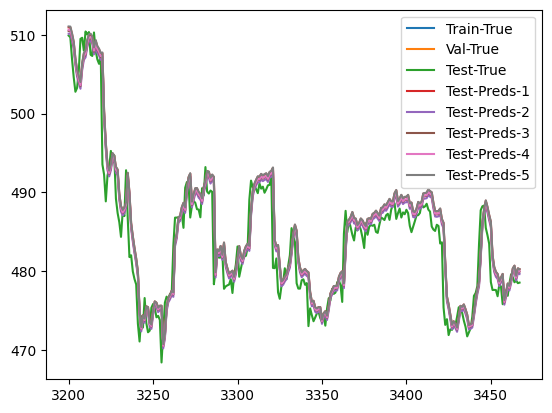

In [62]:
graph_df.iloc[3200:, :].plot()

<Axes: >

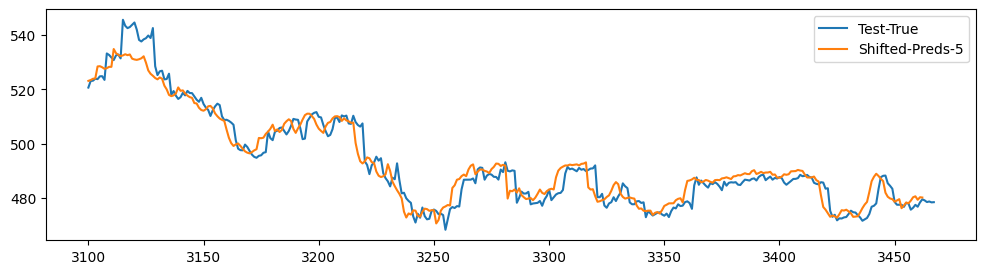

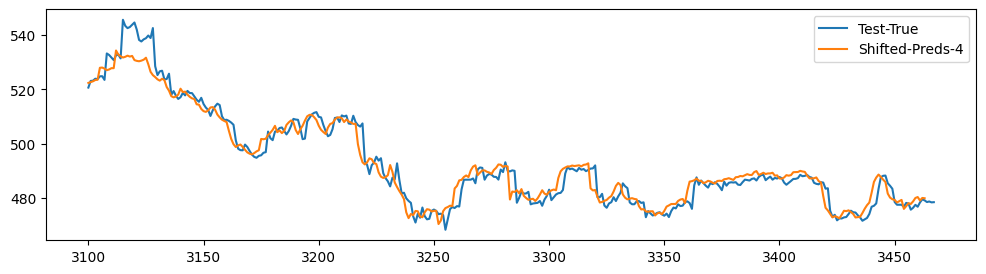

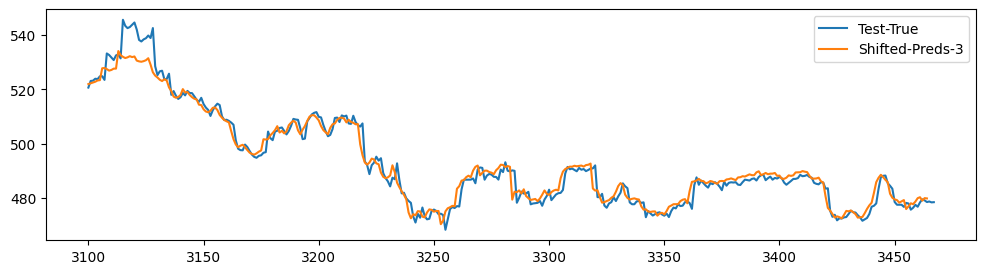

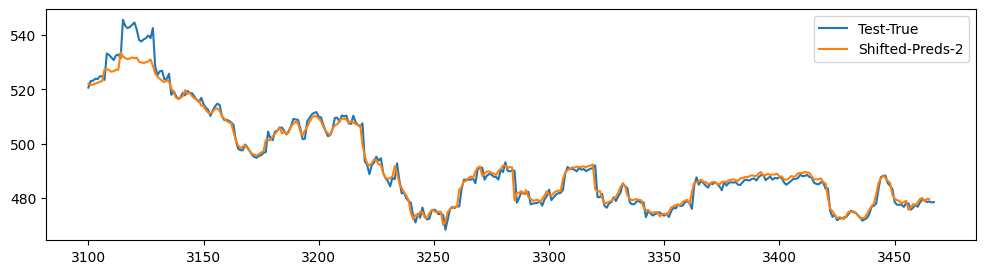

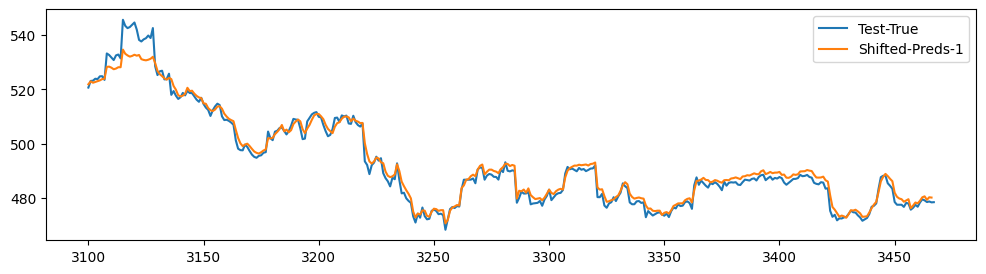

In [66]:
graph_df["Shifted-Preds-1"] = graph_df["Test-Preds-1"].shift(-1)
graph_df["Shifted-Preds-2"] = graph_df["Test-Preds-2"].shift(-2)
graph_df["Shifted-Preds-3"] = graph_df["Test-Preds-3"].shift(-3)
graph_df["Shifted-Preds-4"] = graph_df["Test-Preds-4"].shift(-4)
graph_df["Shifted-Preds-5"] = graph_df["Test-Preds-5"].shift(-5)

graph_df[["Test-True", "Shifted-Preds-5"]].iloc[train_size+val_size:].plot(figsize=(12, 3))
graph_df[["Test-True", "Shifted-Preds-4"]].iloc[train_size+val_size:].plot(figsize=(12, 3))
graph_df[["Test-True", "Shifted-Preds-3"]].iloc[train_size+val_size:].plot(figsize=(12, 3))
graph_df[["Test-True", "Shifted-Preds-2"]].iloc[train_size+val_size:].plot(figsize=(12, 3))
graph_df[["Test-True", "Shifted-Preds-1"]].iloc[train_size+val_size:].plot(figsize=(12, 3))